In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as ss
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
%matplotlib inline

## Load the data

In [2]:
data_path = '/Users/leo/Desktop/DSGA-3001/Project/data/'
data = pd.read_csv(data_path+'application_train.csv')

In [3]:
print(data.shape)

(307511, 122)


In [4]:
# 0 - paid
# 1 - unpaid
data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Target Distribution

In [5]:
### Data is imbalanced

In [6]:
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

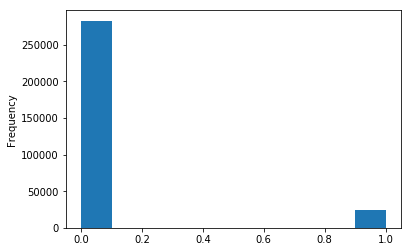

In [7]:
# imbalanced data
data['TARGET'].astype(int).plot.hist()

### Plot of AMT_CREDIT

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


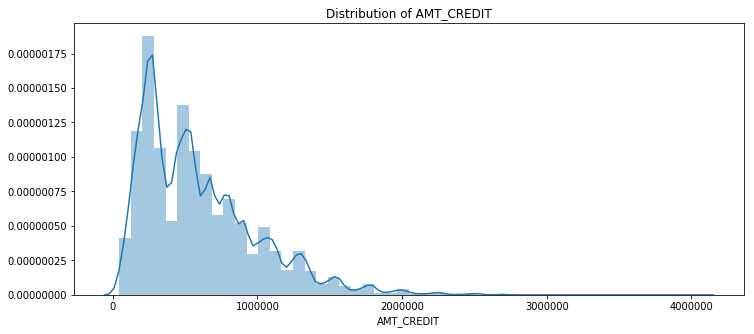

In [8]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(data["AMT_CREDIT"])

## Train-Test Split

In [9]:
X = data.loc[:, data.columns != 'TARGET']
y = data.loc[:, data.columns == 'TARGET']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [11]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (215257, 121)
Number transactions y_train dataset:  (215257, 1)
Number transactions X_test dataset:  (92254, 121)
Number transactions y_test dataset:  (92254, 1)


## Preprocessing

### Missing values

In [12]:
def check_missing_values(dataframe):
    # Create NA Count DataFrame
    nacount = pd.DataFrame(dataframe.isna().sum())
    nacount.columns = ['Count']
    nacount = nacount[(nacount.T != 0).any()]
    nacount['Percentage(%)'] = nacount['Count']/len(X_train)*100
    return nacount 

In [13]:
nacount = check_missing_values(X_train)

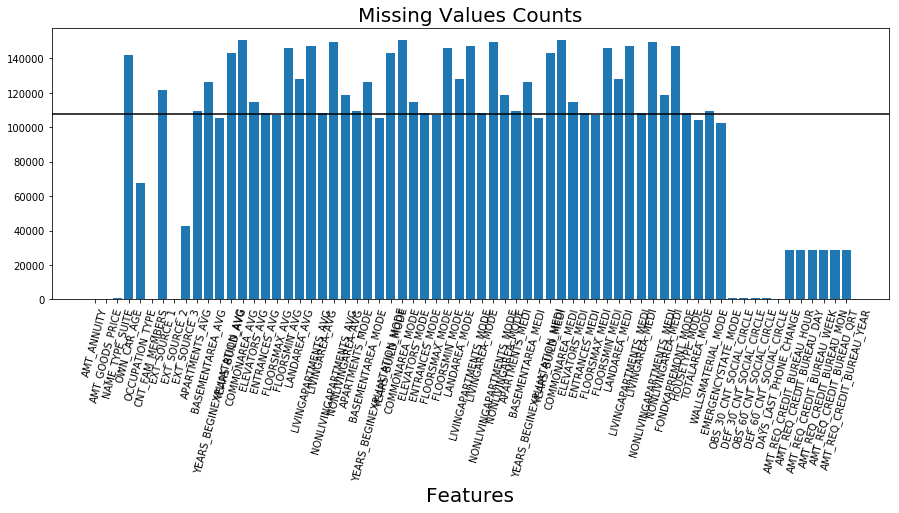

In [14]:
plt.figure(figsize = (15,5))
plt.bar(nacount.index,height = nacount['Count'])
plt.xticks(rotation=75)
plt.xlabel('Features', fontsize = 20)
plt.title('Missing Values Counts', fontsize = 20)
plt.axhline(y=X_train.shape[0]/2, color='black', linestyle='-')
## above: missing more than 50% of data
plt.show()

### Retrieve columns with # missing values > threshold

In [15]:
def filter_out_missing(NAdataframe, threshold):
    nacount_filtered = NAdataframe[NAdataframe['Percentage(%)']>=threshold]
    nacount_sorted = nacount_filtered.sort_index()
    filter_corr = nacount_filtered.index.tolist()
    filter_corr.append("TARGET")
    return nacount_sorted, filter_corr

In [16]:
# get columns with more than 50% missing
nacount_sorted, filter_corr = filter_out_missing(nacount,50)

In [17]:
X_train_corr_copy = X_train.copy()
X_train_corr_copy['TARGET'] = y_train

In [18]:
filter_corr1 = filter_corr[:21]
filter_corr1.append('TARGET')
filter_corr2 = filter_corr[21:]

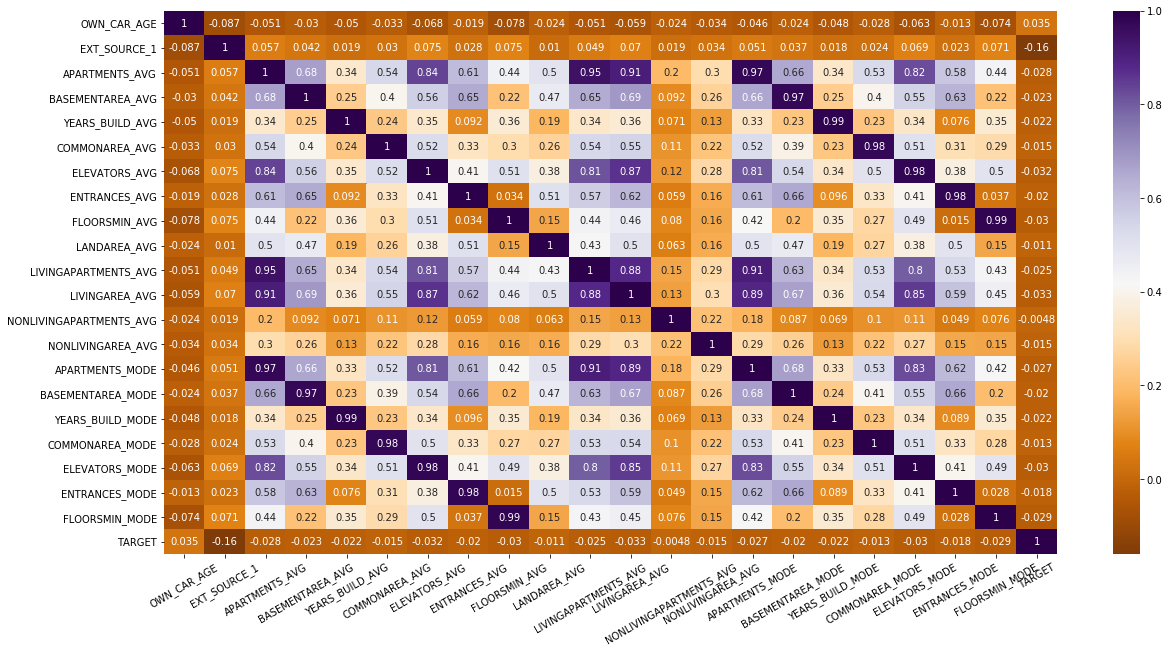

In [19]:
## check correlation for those selected columns
corr1 = X_train_corr_copy[filter_corr1].corr()
fig, ax = plt.subplots(figsize=(20,10))
heatmap = sns.heatmap(corr1, ax=ax, annot=True, cmap="PuOr")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
plt.show()

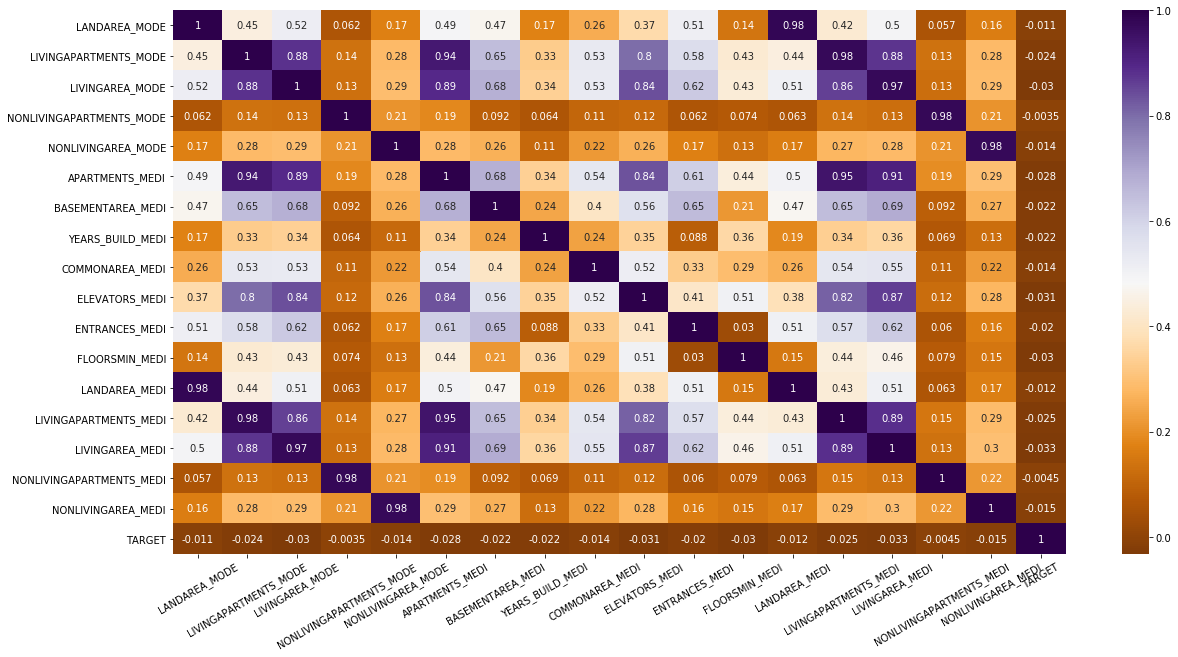

In [20]:
## check correlation for those selected columns
corr2 = X_train_corr_copy[filter_corr2].corr()
fig, ax = plt.subplots(figsize=(20,10))
heatmap = sns.heatmap(corr2, ax=ax, annot=True, cmap="PuOr")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
plt.show()

In [21]:
# From those missing more than 50%, select those features correlated with Target
print(corr1.iloc[-1,:][np.abs(corr1.iloc[-1,:].sort_values()) > 0.1])
# print(corr2.iloc[-1,:][np.abs(corr2.iloc[-1,:].sort_values()) > 0.1])

EXT_SOURCE_1   -0.160713
TARGET          1.000000
Name: TARGET, dtype: float64


In [22]:
filter_corr.remove('EXT_SOURCE_1')
filter_corr.remove('TARGET')

### Drop those columns from train and test; Keep Median values, drop mode and avg

In [23]:
# Keep Median values, drop mode and avg
drop_label = [x for x in filter_corr if 'MEDI' not in x]

In [24]:
def first_drop_stage(dataframe, drop_label):
    dataframe = dataframe.drop(labels = drop_label, axis = 1)
    return dataframe

In [25]:
print(len(drop_label))
print(X_train.shape)

28
(215257, 121)


In [26]:
X_train = first_drop_stage(X_train, drop_label)
X_test = first_drop_stage(X_test, drop_label)

In [27]:
# Drop 28 columns from 121 columns
# 93 remains
print(X_train.shape)
print(X_test.shape)

(215257, 93)
(92254, 93)


### Pickout numeric and categorical features

In [28]:
## Optimize
types_list = ['object', 'int64', 'float64']
def get_type_col(dataframe, types_list):
    type_col = {}
    for i in types_list:        
        type_col[i] = dataframe.dtypes[dataframe.dtypes == i].index.tolist()
    return type_col

type_col = get_type_col(X_train, types_list)


In [29]:
object_type_col = type_col['object']
int64_type_col = type_col['int64']
float64_type_col = type_col['float64']
print('There are {} columns are "object" type'.format(len(object_type_col)))
print('There are {} columns are "int64" type'.format(len(int64_type_col)))
print('There are {} columns are "float64" type'.format(len(float64_type_col)))

There are 13 columns are "object" type
There are 40 columns are "int64" type
There are 40 columns are "float64" type


In [30]:
def get_cat_numeric(dataframe, type_col):
    ## retrieve categorical features from int64_col
    cat_in_int64 = []
    for item in type_col['int64']:
        if ('FLAG_' in item) or ('REG_' in item) or ('LIVE_' in item) or ('HOUR_APPR' in item):
            cat_in_int64.append(item) 
    cat_feature = type_col['object'] + cat_in_int64
    
    # get numerical features
    num_feature = [x for x in dataframe.columns.values.tolist() if x not in cat_feature]
    num_feature.remove('SK_ID_CURR')
    return cat_feature, num_feature

In [31]:
cat_feature, num_feature = get_cat_numeric(X_train, type_col)

In [32]:
print('There are {} numeric feature'.format(len(num_feature)))
print('There are {} categorical feature'.format(len(cat_feature)))

There are 46 numeric feature
There are 46 categorical feature


### Handle missing values in categorical features

In [33]:
# Check missing values inside category features
X_train[cat_feature].isna().sum()

NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
NAME_TYPE_SUITE                   904
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
OCCUPATION_TYPE                 67553
WEEKDAY_APPR_PROCESS_START          0
ORGANIZATION_TYPE                   0
EMERGENCYSTATE_MODE            102265
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE                          0
FLAG_EMAIL                          0
HOUR_APPR_PROCESS_START             0
REG_REGION_NOT_LIVE_REGION          0
REG_REGION_NOT_WORK_REGION          0
LIVE_REGION_NOT_WORK_REGION         0
REG_CITY_NOT_LIVE_CITY              0
REG_CITY_NOT_WORK_CITY              0
LIVE_CITY_NOT_WORK_CITY             0
FLAG_DOCUMEN

In [34]:
### Occupation_type - flag as unknown

In [35]:
## the most missing class - flag as unknown - 67553 missing
## fill missing values with Unknown
print(X_train.isna().sum()['OCCUPATION_TYPE'])
X_train['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)
X_test['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

67553


In [36]:
### Emergencystate_mode - drop

In [37]:
## Drop the column - 102265 missing
## check correlation
X_train.isna().sum()['EMERGENCYSTATE_MODE']

102265

In [38]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [39]:
confusion_matrix = pd.crosstab(X_train['EMERGENCYSTATE_MODE'], y_train['TARGET'])
confusion_matrix

TARGET,0,1
EMERGENCYSTATE_MODE,,
No,103500,7850
Yes,1479,163


In [40]:
cramers_corrected_stat(confusion_matrix)

0.012931465360096426

In [41]:
## Drop from both train and test

In [42]:
X_train = X_train.drop(labels = 'EMERGENCYSTATE_MODE', axis = 1)
X_test = X_test.drop(labels = 'EMERGENCYSTATE_MODE', axis = 1)
cat_feature.remove('EMERGENCYSTATE_MODE')

In [43]:
## Name_type_suite - merge the last three minority groups together as 'others'

In [44]:
X_train.isna().sum()['NAME_TYPE_SUITE']

904

In [45]:
X_train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      173927
Family              28148
Spouse, partner      7943
Children             2272
Other_B              1269
Other_A               606
Group of people       188
Name: NAME_TYPE_SUITE, dtype: int64

In [46]:
merge_groups_list = X_train['NAME_TYPE_SUITE'].value_counts().index.tolist()[-3:]
def handle_name_type_suite(dataframe, merge_groups_list):
    dataframe['NAME_TYPE_SUITE'].fillna('Others', inplace=True)
    for i in merge_groups_list:
        dataframe['NAME_TYPE_SUITE'].loc[dataframe['NAME_TYPE_SUITE'] == i] = 'Others'

In [47]:
handle_name_type_suite(X_train, merge_groups_list)
handle_name_type_suite(X_test, merge_groups_list)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
## No missing values in both train and test categorical features

In [49]:
print(X_train[cat_feature].isna().sum().sum())
print(X_test[cat_feature].isna().sum().sum())

0
0


### Handle missing values in numeric features

In [50]:
X_train[num_feature].isna().sum()

CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         10
AMT_GOODS_PRICE                    194
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
CNT_FAM_MEMBERS                      1
REGION_RATING_CLIENT                 0
REGION_RATING_CLIENT_W_CITY          0
EXT_SOURCE_1                    121488
EXT_SOURCE_2                       488
EXT_SOURCE_3                     42632
YEARS_BEGINEXPLUATATION_AVG     105173
FLOORSMAX_AVG                   107261
YEARS_BEGINEXPLUATATION_MODE    105173
FLOORSMAX_MODE                  107261
APARTMENTS_MEDI                 109407
BASEMENTAREA_MEDI               126106
YEARS_BEGINEXPLUATATION_MEDI    105173
YEARS_BUILD_MEDI                143257
COMMONAREA_MEDI                 150436
ELEVATORS_MEDI           

In [51]:
## ['YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'TOTALAREA_MODE']
## ['YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG'] should be removed
mode_list = [x for x in num_feature if '_MODE' in x]
avg_list = [x for x in num_feature if '_AVG' in x]
drop_label_avg_mode = mode_list + avg_list
X_train = X_train.drop(labels = drop_label_avg_mode, axis = 1)
X_test = X_test.drop(labels = drop_label_avg_mode, axis = 1)

In [52]:
num_feature = [x for x in num_feature if x not in mode_list]
num_feature = [x for x in num_feature if x not in avg_list]

In [53]:
X_train[num_feature].isna().sum()

CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         10
AMT_GOODS_PRICE                    194
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
CNT_FAM_MEMBERS                      1
REGION_RATING_CLIENT                 0
REGION_RATING_CLIENT_W_CITY          0
EXT_SOURCE_1                    121488
EXT_SOURCE_2                       488
EXT_SOURCE_3                     42632
APARTMENTS_MEDI                 109407
BASEMENTAREA_MEDI               126106
YEARS_BEGINEXPLUATATION_MEDI    105173
YEARS_BUILD_MEDI                143257
COMMONAREA_MEDI                 150436
ELEVATORS_MEDI                  114867
ENTRANCES_MEDI                  108534
FLOORSMAX_MEDI                  107261
FLOORSMIN_MEDI                  146149
LANDAREA_MEDI            

In [54]:
def handle_numerical_features(train_base, dataframe, num_feature):
    for item in num_feature:
        if dataframe[item].isna().sum() != 0:
            dataframe[item].fillna((train_base[item].median()), inplace=True) 

In [55]:
handle_numerical_features(X_train, X_train, num_feature)
handle_numerical_features(X_train, X_test, num_feature)

In [56]:
print(X_train[cat_feature].isna().sum().sum())
print(X_test[cat_feature].isna().sum().sum())

0
0


In [69]:
columns_name = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']

In [70]:
from itertools import combinations_with_replacement

In [71]:
c = list(combinations_with_replacement(columns_name, r=2))

In [72]:
c

[('EXT_SOURCE_1', 'EXT_SOURCE_1'),
 ('EXT_SOURCE_1', 'EXT_SOURCE_2'),
 ('EXT_SOURCE_1', 'EXT_SOURCE_3'),
 ('EXT_SOURCE_1', 'DAYS_BIRTH'),
 ('EXT_SOURCE_2', 'EXT_SOURCE_2'),
 ('EXT_SOURCE_2', 'EXT_SOURCE_3'),
 ('EXT_SOURCE_2', 'DAYS_BIRTH'),
 ('EXT_SOURCE_3', 'EXT_SOURCE_3'),
 ('EXT_SOURCE_3', 'DAYS_BIRTH'),
 ('DAYS_BIRTH', 'DAYS_BIRTH')]

In [73]:
X_train['EXT_SOURCE_1'].dtypes

dtype('float64')

In [74]:
from numba import vectorize, float64

In [75]:
@vectorize([float64(float64,float64)])
def vec_mul(a,b):
    return a*b

In [76]:
for i in c:
    X_train[i] = vec_mul(X_train[i[0]], X_train[i[1]])
    X_test[i] = vec_mul(X_test[i[0]], X_test[i[1]])  

## At this stage, all missing values should be handled

In [57]:
print(X_train.shape)
print(X_test.shape)

(215257, 87)
(92254, 87)


In [58]:
print(len(cat_feature),len(num_feature))

45 41


## Rescale numeric features

In [57]:
def feature_normalization(base, dataset, columns_sel):
    dataset[columns_sel] = (dataset[columns_sel] - base[columns_sel].min(axis=0))/ \
    (base[columns_sel].max(axis=0) - base[columns_sel].min(axis=0))
    return dataset

In [58]:
X_train = feature_normalization(X_train, X_train, num_feature)
X_test = feature_normalization(X_train, X_test, num_feature)

## Create dummy variables

In [59]:
flag_word_to_number_list = ['FLAG_OWN_CAR', 'CODE_GENDER', 'FLAG_OWN_REALTY']

def handle_word(dataframe, flag_list):
    for item in flag_list:
        if 'Y' in list(dataframe[item]):
            dataframe[item] = dataframe[item].map({'Y': 1, 'N': 0})
        elif 'F' in list(dataframe[item]):
            dataframe[item] = dataframe[item].map({'F': 1, 'M': 0})
    dataframe['CODE_GENDER'].fillna(0, inplace=True)

In [60]:
def create_dummy(dataframe):
    dummy_feature = [i for i in cat_feature if 'FLAG_' not in i]
    dummy_feature.remove('CODE_GENDER')
    X_prepared = pd.get_dummies(dataframe, columns=dummy_feature)
    return X_prepared

In [61]:
handle_word(X_train, flag_word_to_number_list)
handle_word(X_test, flag_word_to_number_list)
X_train = create_dummy(X_train)
X_test = create_dummy(X_test)

In [62]:
print(X_train.shape, X_test.shape)

(215257, 223) (92254, 223)


## Anomalies Detection

In [63]:
(X_train['DAYS_BIRTH'] / 365).describe()
# seems fine

count    215257.000000
mean          0.001419
std           0.000674
min           0.000000
25%           0.000855
50%           0.001461
75%           0.001979
max           0.002740
Name: DAYS_BIRTH, dtype: float64

In [64]:
(X_train['DAYS_EMPLOYED']).describe()

count    215257.000000
mean          0.212862
std           0.369238
min           0.000000
25%           0.038720
50%           0.042750
75%           0.045172
max           1.000000
Name: DAYS_EMPLOYED, dtype: float64

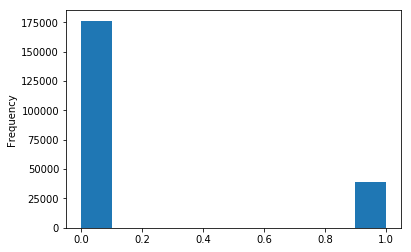

In [65]:
(X_train['DAYS_EMPLOYED']).plot.hist()

In [66]:
# There are some extreme values, which is not possible
# Fill with median
X_train['DAYS_EMPLOYED'].replace({1: np.nan}, inplace = True)
X_train['DAYS_EMPLOYED'].fillna(X_train['DAYS_EMPLOYED'].median(), inplace=True)

In [67]:
(X_train['DAYS_EMPLOYED']).describe()

count    215257.000000
mean          0.040044
std           0.005582
min           0.000000
25%           0.038720
50%           0.041622
75%           0.043479
max           0.045929
Name: DAYS_EMPLOYED, dtype: float64

In [68]:
# Do the same for test
# fill with train median
X_test['DAYS_EMPLOYED'].replace({1: np.nan}, inplace = True)
X_test['DAYS_EMPLOYED'].fillna(X_train['DAYS_EMPLOYED'].median(), inplace=True)

## Domain Knowledge Feature Extraction

In [260]:
X_train['CREDIT_INCOME_PERCENT'] = X_train['AMT_CREDIT'] / X_train['AMT_INCOME_TOTAL']
X_train['ANNUITY_INCOME_PERCENT'] = X_train['AMT_ANNUITY'] / X_train['AMT_INCOME_TOTAL']
X_train['CREDIT_TERM'] = X_train['AMT_ANNUITY'] / X_train['AMT_CREDIT']
X_train['DAYS_EMPLOYED_PERCENT'] = X_train['DAYS_EMPLOYED'] / X_train['DAYS_BIRTH']

In [261]:
X_train['CREDIT_TERM'].fillna(X_train['CREDIT_TERM'].median(), inplace=True)

In [262]:
X_train['CREDIT_TERM'][X_train['CREDIT_TERM'] == np.inf] = X_train['CREDIT_TERM'].median()
X_train['CREDIT_INCOME_PERCENT'][X_train['CREDIT_INCOME_PERCENT'] == np.inf] = \
X_train['CREDIT_INCOME_PERCENT'].median()
X_train['ANNUITY_INCOME_PERCENT'][X_train['ANNUITY_INCOME_PERCENT'] == np.inf] = \
X_train['ANNUITY_INCOME_PERCENT'].median()
X_train['DAYS_EMPLOYED_PERCENT'][X_train['DAYS_EMPLOYED_PERCENT'] == np.inf] = \
X_train['DAYS_EMPLOYED_PERCENT'].median()


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: Sett

In [263]:
X_test['CREDIT_INCOME_PERCENT'] = X_test['AMT_CREDIT'] / X_test['AMT_INCOME_TOTAL']
X_test['ANNUITY_INCOME_PERCENT'] = X_test['AMT_ANNUITY'] / X_test['AMT_INCOME_TOTAL']
X_test['CREDIT_TERM'] = X_test['AMT_ANNUITY'] / X_test['AMT_CREDIT']
X_test['DAYS_EMPLOYED_PERCENT'] = X_test['DAYS_EMPLOYED'] / X_test['DAYS_BIRTH']

In [264]:
(X_train == np.inf).sum().sum()

0

In [265]:
(X_test == np.inf).sum().sum()

0

## Modeling Stage

### Naive Bayes --- assumes indenpendent features

In [94]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [95]:
print('AUC score is for Naive Bayes is : ', metrics.roc_auc_score(y_test, y_pred))

AUC score is for Naive Bayes is :  0.6267885342111483


### Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
print(np.sum(y_train['TARGET']==1))
print(np.sum(y_train['TARGET']==0))
weight_0 = np.sum(y_train['TARGET']==0) / (np.sum(y_train['TARGET']==0) + np.sum(y_train['TARGET']==1))
weight_1 = 1 - weight_0

17485
197772


In [90]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [91]:
logreg = LogisticRegression(class_weight={0:weight_0, 1:weight_1})
logreg.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0,
          class_weight={0: 0.9187715149797684, 1: 0.08122848502023161},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

In [92]:
y_pred = logreg.predict_proba(X_test)[:, 1]

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [93]:
print('AUC score for Logistic Regression is: ', metrics.roc_auc_score(y_test, y_pred))

AUC score for Logistic Regression is:  0.5


### SVM --- take too long

In [274]:
from sklearn import svm

In [275]:
# clf = svm.SVC(kernel='linear') 
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [276]:
print("AUC:", metrics.roc_auc_score(y_test, y_pred))

AUC: 0.5106461729286738


### Random Forest

In [277]:
from sklearn.ensemble import RandomForestClassifier

In [278]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, max_depth=None,
                                       class_weight={0:weight_0, 1:weight_1})

In [279]:
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
# feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [280]:
# Make predictions on the test data
y_pred = random_forest.predict_proba(X_test)[:, 1]

In [281]:
print('AUC score for Random Forest is: ', metrics.roc_auc_score(y_test, y_pred))

AUC score for Random Forest is:  0.6467326518980352


### LightGBM

In [97]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [98]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [99]:
params = {
     'task': 'train',
     'objective':'binary',
     'metric': 'auc',
     'verbose': 0,
     'binary'
     'max_bin': 128,  # 大会有更准的效果,更慢的速度
     'learning_rate': 0.01,  # 学习率
     'num_leaves': 150,  # 大会更准,但可能过拟合
     'num_iterations': 50,
     'early_stopping_round': 5,
     'min_data_in_leaf': 5,
     'max_depth': 10,
    }

In [100]:
gbm = lgb.train(params,lgb_train, valid_sets = [lgb_eval], verbose_eval = False)
print(gbm.best_score['valid_0'])

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


{'auc': 0.70136860461288}
